In [27]:
!cat ai.ja.txt | cabocha -f1 > ai.ja.txt.parsed

# 40.係り受け解析の読み込み

In [3]:
import re

class Morph:
    def __init__(self, line):
        
        cols = re.split ( '\t|,',line)
        self.surface = cols[0]
        self.base = cols[7]    
        self.pos = cols[1]     
        self.pos1 = cols[2]    
        
res = []
morph = []

with open('ai.ja.txt.parsed') as f:    
    for line in f:
         
        if re.match('EOS\n',line):   
            res.append(morph)
            morph =[]           
        else:
            if line[0] == '*':
                continue
            else:               
                morph.append(Morph(line))
        
for i in res[2][:10]:
    print(vars(i))

{'surface': '人工', 'base': '人工', 'pos': '名詞', 'pos1': '一般'}
{'surface': '知能', 'base': '知能', 'pos': '名詞', 'pos1': '一般'}
{'surface': '（', 'base': '（', 'pos': '記号', 'pos1': '括弧開'}
{'surface': 'じん', 'base': 'じん', 'pos': '名詞', 'pos1': '一般'}
{'surface': 'こうち', 'base': 'こうち', 'pos': '名詞', 'pos1': '一般'}
{'surface': 'のう', 'base': 'のう', 'pos': '助詞', 'pos1': '終助詞'}
{'surface': '、', 'base': '、', 'pos': '記号', 'pos1': '読点'}
{'surface': '、', 'base': '、', 'pos': '記号', 'pos1': '読点'}
{'surface': 'AI', 'base': '*\n', 'pos': '名詞', 'pos1': '一般'}
{'surface': '〈', 'base': '〈', 'pos': '記号', 'pos1': '括弧開'}


# 41.係り受け解析結果の読み込み

In [4]:
class Morph:
    def __init__(self, line):

        cols = re.split ( '\t|,',line)
        self.surface = cols[0] 
        self.base = cols[7]    
        self.pos = cols[1]     
        self.pos1 = cols[2]    

class Chunk:
    def __init__(self, morphs, dst):
        self.morphs = morphs
        self.srcs = []   
        self.dst  = dst  
        self.phrase = ''.join([morph.surface for morph in morphs]) 
        
          
        self.joshi = ''
        self.verb = ''
        self.sahen = ''
        
 #          if morph.pos != '記号':
 #               self.joshi = ''  # 記号を除いた最終行の助詞を取得するため、記号以外の場合はブランク
 #           if morph.pos == '動詞':
 #               self.verb = morph.base
 #           if morph.pos == '助詞':
 #               self.joshi = morph.base
                
            
def add_sentence(chunks, sentences):
    for i, chunk in enumerate(chunks):
        if chunk.dst != -1:
            chunks[chunk.dst].srcs.append(i)
    sentences.append(chunks)
    return sentences, []

morphs = []
chunks = []
sentences = []

with open('ai.ja.txt.parsed') as f:

    for line in f:
        dependancies = re.match(r'(?:\*\s\d+\s)(-?\d+)',line ,re.VERBOSE)
        if not (line == 'EOS\n' or dependancies or line[0] == '。'):
            morphs.append(Morph(line))
        elif len(morphs) > 0:
            chunks.append(Chunk(morphs, dst))
            morphs = []
        if dependancies:
            dst = int(dependancies.group(1))
        if line == 'EOS\n' and len(chunks) > 0:
            sentences, chunks = add_sentence(chunks, sentences)

for i, chunk in enumerate(sentences[1]):
    print('{}: {}, dst:{}, srcs:{}'.format(i, chunk.phrase, chunk.dst, chunk.srcs))

0: 人工知能, dst:17, srcs:[]
1: （じんこうちのう、、, dst:17, srcs:[]
2: AI, dst:3, srcs:[]
3: 〈エーアイ〉）とは、, dst:17, srcs:[2]
4: 「『計算, dst:5, srcs:[]
5: （）』という, dst:9, srcs:[4]
6: 概念と, dst:9, srcs:[]
7: 『コンピュータ, dst:8, srcs:[]
8: （）』という, dst:9, srcs:[7]
9: 道具を, dst:10, srcs:[5, 6, 8]
10: 用いて, dst:12, srcs:[9]
11: 『知能』を, dst:12, srcs:[]
12: 研究する, dst:13, srcs:[10, 11]
13: 計算機科学, dst:14, srcs:[12]
14: （）の, dst:15, srcs:[13]
15: 一分野」を, dst:16, srcs:[14]
16: 指す, dst:17, srcs:[15]
17: 語, dst:-1, srcs:[0, 1, 3, 16]


# 42.係り元と係り先の文節の表示

In [67]:
for sentence in sentences[:2]:
    for chunk in sentence:
        if chunk.dst != -1:
            print('{}\t{}'.format(chunk.phrase, sentence[chunk.dst].phrase))

人工知能	語
（じんこうちのう、、	語
AI	〈エーアイ〉）とは、
〈エーアイ〉）とは、	語
「『計算	（）』という
（）』という	道具を
概念と	道具を
『コンピュータ	（）』という
（）』という	道具を
道具を	用いて
用いて	研究する
『知能』を	研究する
研究する	計算機科学
計算機科学	（）の
（）の	一分野」を
一分野」を	指す
指す	語


# 43.名刺を含む文節が動詞を含む文節に係るものを抽出

In [68]:
for sentence in sentences[:2]:
    for k in sentence:
        if any(m.pos == '名詞' for m in k.morphs) and any(m.pos == '動詞' for m in sentence[k.dst].morphs):
            print(k.phrase + '\t' + sentence[k.dst].phrase)

道具を	用いて
『知能』を	研究する
一分野」を	指す


# 44.係り受け木の可視化Permalink

In [69]:
from graphviz import Digraph

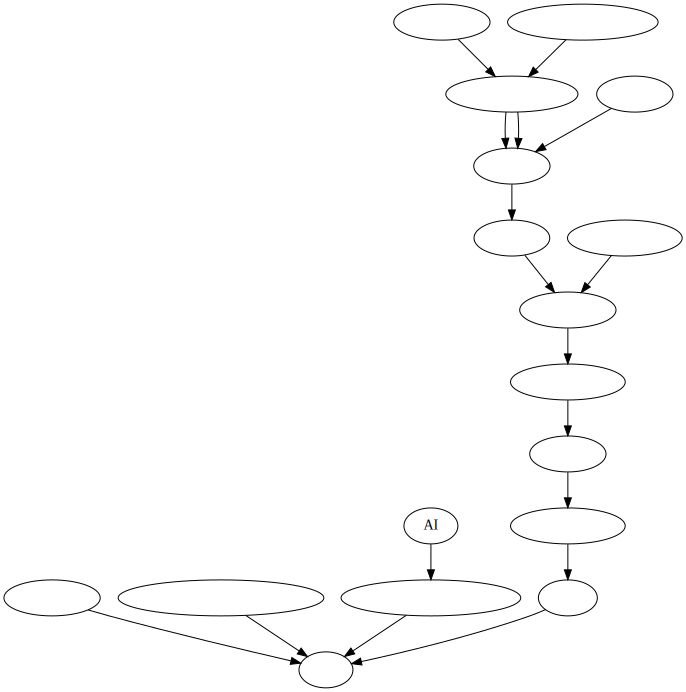

In [70]:
Image = Digraph(format='png')

for sentence in sentences[:2]:
    for chunk in sentence:
            Image.node(chunk.phrase)
    
for i in sentences[:1]:
    for chunk in sentence:        
        if chunk.dst != -1:
            Image.edge(chunk.phrase,sentence[chunk.dst].phrase)
        
Image

# 45.動詞の各パターンの抽出

In [71]:
with open('045.result.txt', 'w') as out_file:
    for sentence in sentences:
        for chunk in sentence:
            if chunk.verb != '' and len(chunk.srcs) > 0:
                sources = [sentence[source].joshi for source in chunk.srcs if sentence[source].joshi != '']
                if len(sources) > 0:
                    sources.sort()
                    out_file.write(('{}\t{}\n'.format(chunk.verb, ' '.join(sources))))

In [72]:
!cat 045.result.txt | cut -f 1 | sort | uniq -c | sort -k 1,1 -r | head -n 5

 183 する
 110 いる
  53 れる
  28 なる
  26 ある


In [73]:
!cat 045.result.txt | sort -k 1,1 | uniq -c | sort -k 1,1 -r | head -n 5

  49 する	を
  14 する	と
  11 よる	に
  10 する	に
  10 する	が


# 46.動詞の格フレーム情報の抽出

In [44]:
def output_file(out_file, sentence, chunk):
    sources = [[sentence[source].joshi, sentence[source].phrase] \
                for source in chunk.srcs if sentence[source].joshi != '']

    if len(sources) > 0:
        sources.sort()
        joshi = ' '.join([row[0] for row in sources])
        phrase = ' '.join([row[1] for row in sources])
        out_file.write(('{}\t{}\t{}\n'.format(chunk.verb, joshi, phrase)))

with open('./046.result.txt', 'w') as out_file:
    for sentence in sentences:
        for chunk in sentence:
            if chunk.verb != '' and len(chunk.srcs) > 0:
                output_file(out_file, sentence, chunk)

In [46]:
! head -n 5 046.result.txt

用いる	を	道具を
する	て を	用いて 『知能』を
指す	を	一分野」を
代わる	に を	人間に 知的行動を
せる	て に	代わって コンピューターに


# 47.機能動詞構文のマイニング

In [56]:
class Morph:
    def __init__(self, line):

        cols = re.split ( '\t|,',line)
        self.surface = cols[0] 
        self.base = cols[7]    
        self.pos = cols[1]     
        self.pos1 = cols[2]    

class Chunk:
    def __init__(self, morphs, dst):
        self.morphs = morphs
        self.srcs = []   
        self.dst  = dst  

        self.phrase = ''
        self.verb = ''
        self.joshi = ''
        self.sahen = '' 

        for i, morph in enumerate(morphs):
            if morph.pos != '記号':
                self.phrase += morph.surface 
                self.joshi = ''  

            if morph.pos == '動詞' and self.verb == '':
                self.verb = morph.base

            if morphs[-1].pos == '助詞':
                self.joshi = morphs[-1].base

            try:
                if morph.pos1 == 'サ変接続' and \
                   morphs[i+1].surface == 'を':
                    self.sahen = morph.surface + morphs[i+1].surface
            except IndexError:
                pass
            
def add_sentence(chunks, sentences):
    for i, chunk in enumerate(chunks):
        if chunk.dst != -1:
            chunks[chunk.dst].srcs.append(i)
    sentences.append(chunks)
    return sentences, []

morphs = []
chunks = []
sentences = []

with open('ai.ja.txt.parsed') as f:

    for line in f:
        dependancies = re.match(r'(?:\*\s\d+\s)(-?\d+)',line ,re.VERBOSE)
        if not (line == 'EOS\n' or dependancies or line[0] == '。'):
            morphs.append(Morph(line))
        elif len(morphs) > 0:
            chunks.append(Chunk(morphs, dst))
            morphs = []
        if dependancies:
            dst = int(dependancies.group(1))
        if line == 'EOS\n' and len(chunks) > 0:
            sentences, chunks = add_sentence(chunks, sentences)

In [57]:
def output_file(out_file, sahen, sentence, chunk):
    sources = [[sentence[source].joshi, sentence[source].phrase] \
                for source in chunk.srcs if sentence[source].joshi != '']

    if len(sources) > 0:
        sources.sort()
        joshi = ' '.join([row[0] for row in sources])
        phrase = ' '.join([row[1] for row in sources])
        out_file.write(('{}\t{}\t{}\n'.format(sahen, joshi, phrase)))

with open('./047.result.txt', 'w') as out_file:
    for sentence in sentences:
        for chunk in sentence:

            if chunk.sahen != '' and \
               chunk.dst != -1 and \
               sentence[chunk.dst].verb != '':
                output_file(out_file, chunk.sahen+sentence[chunk.dst].verb, 
                            sentence, sentence[chunk.dst])

In [58]:
! head -n 5 047.result.txt

行動を代わる	に を	人間に 知的行動を
判断をする	を	推論判断を
処理を用いる	を	記号処理を
記述をする	と を	主体と 記述を
注目を集める	が を	サポートベクターマシンが 注目を


# 48.名詞から根へのパスへの抽出

In [59]:
sentence = sentences[33]
for chunk in sentence:
    if '名詞' in [morph.pos for morph in chunk.morphs]: 
        line = chunk.phrase
        current_chunk = chunk
        while current_chunk.dst != -1:
            line = line + ' -> ' + sentence[current_chunk.dst].phrase
            current_chunk = sentence[current_chunk.dst]
        print(line)

ジョンマッカーシーは -> 作り出した
AIに関する -> 最初の -> 会議で -> 作り出した
最初の -> 会議で -> 作り出した
会議で -> 作り出した
人工知能という -> 用語を -> 作り出した
用語を -> 作り出した


# 49.名詞間の係り受けパスの抽出

In [7]:
sentence = sentences[33]
chunk_nouns = [i for i,chunk in enumerate(sentence) if '名詞' in [morph.pos for morph in chunk.morphs]]
#パスの先頭
chunk_nouns

[0, 1, 2, 3, 4, 5]

In [8]:
pairs = [(chunk_nouns[i], j) for i in range(len(chunk_nouns)) for j in chunk_nouns[i+1:]]
#パスの先頭のペア
pairs

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (2, 3),
 (2, 4),
 (2, 5),
 (3, 4),
 (3, 5),
 (4, 5)]

In [47]:
#係り受けのパス
for i, j in pairs:  
    path_i = []
    path_j = []
 #   print(i,j)
    while i != j:
        if i < j:
            path_i.append(i)
            i = sentence[i].dst
        else:
            path_j.append(j)
            j = sentence[j].dst
    print(i,j)
    print(path_i)
    print(path_j)
    if len(path_j) == 0:  
        xs = ''.join([morph.surface if morph.pos != '名詞' else 'X' for morph in sentence[path_i[0]].morphs])
        xs = re.sub('X+', 'X', xs)
        ys = ''.join([morph.surface if morph.pos != '名詞' else 'Y' for morph in sentence[i].morphs])
        ys = re.sub('Y+', 'Y', ys)
        xy = [xs] + [''.join(morph.surface for morph in sentence[n].morphs) for n in path_i[1:]] + [ys]
        print(' -> '.join(xy))
    else:
        xs = ''.join([morph.surface if morph.pos != '名詞' else 'X' for morph in sentence[path_i[0]].morphs])
        xs = re.sub('X+', 'X', xs)
        xs = re.sub('X・X','X', xs)
        ys = ''.join([morph.surface if morph.pos != '名詞' else 'Y' for morph in sentence[path_j[0]].morphs])
        ks = ''.join([morph.surface for morph in sentence[-1].morphs])
        ys = re.sub('Y+', 'Y', ys)
        x = [xs] + [''.join(morph.surface for morph in sentence[n].morphs) for n in path_i[1:]]
        y = [ys] + [''.join(morph.surface for morph in sentence[n].morphs) for n in path_j[1:]]
        print(' | '.join([' -> '.join(x), ' -> '.join(y),ks]))

6 6
[0]
[1, 2, 3]
Xは | Yに関する -> 最初の -> 会議で | 作り出した
6 6
[0]
[2, 3]
Xは | Yの -> 会議で | 作り出した
6 6
[0]
[3]
Xは | Yで | 作り出した
6 6
[0]
[4, 5]
Xは | 「Y」という -> 用語を | 作り出した
6 6
[0]
[5]
Xは | Yを | 作り出した
2 2
[1]
[]
Xに関する -> Yの
3 3
[1, 2]
[]
Xに関する -> 最初の -> Yで
6 6
[1, 2, 3]
[4, 5]
Xに関する -> 最初の -> 会議で | 「Y」という -> 用語を | 作り出した
6 6
[1, 2, 3]
[5]
Xに関する -> 最初の -> 会議で | Yを | 作り出した
3 3
[2]
[]
Xの -> Yで
6 6
[2, 3]
[4, 5]
Xの -> 会議で | 「Y」という -> 用語を | 作り出した
6 6
[2, 3]
[5]
Xの -> 会議で | Yを | 作り出した
6 6
[3]
[4, 5]
Xで | 「Y」という -> 用語を | 作り出した
6 6
[3]
[5]
Xで | Yを | 作り出した
5 5
[4]
[]
「X」という -> Yを


In [31]:
for i in sentence[0].morphs:
    print(i.surface)

ジョン
・
マッカーシー
は
